<a href="https://colab.research.google.com/github/vidya100804/AI-ML/blob/main/py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Set seed
np.random.seed(31415926)


In [50]:
df_fishing_vessels = pd.read_csv("/content/fishing-vessels-v2.csv")
df_loiter_carrier = pd.read_csv("/content/carrier_loitering_v20210408.csv")
df_loiter_bunker = pd.read_csv("/content/bunker_loitering_v20210408.csv")
df_model_raw = pd.read_csv("/content/s1_training_final.csv")
df_model_labels = pd.read_csv("/content/s4_final_model_predictions.csv")
print("Loaded successfully")

Loaded successfully


In [51]:
# Cleanup data and merge different DataFrames to get the final required dataset
merge_on = ["hours","fishing_hours","average_daily_fishing_hours","fishing_hours_foreign_eez","fishing_hours_high_seas","distance_traveled_km"]
df_model = pd.merge(df_model_raw[merge_on + ["mmsi"]],df_model_labels, on=merge_on, how="right" )
# https://stackoverflow.com/questions/15222754/groupby-pandas-dataframe-and-select-most-common-value
df_grouped_mmsi = df_model.groupby("mmsi")["Prediction"].apply(pd.Series.mode).reset_index()#.agg(pd.Series.mode).reset_index()
df_grouped_mmsi = df_grouped_mmsi.drop_duplicates(subset=['mmsi'], keep="last")
df_loiter_data_carrier = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_carrier, left_on="mmsi", right_on="carrier_mmsi", how="right")
df_loiter_data_bunker = pd.merge(df_grouped_mmsi[["mmsi","Prediction"]], df_loiter_bunker, left_on="mmsi", right_on="bunker_mmsi", how="right")
df_loiter_data = pd.concat([df_loiter_data_carrier,df_loiter_data_bunker])

## Define Class Labeling and encode classes to chosen definitions
IUU_LABEL = 0
NON_IUU_LABEL = 1
UNLABELLED = -1
# Get loiter start hour of day feature. This feature can be useful
df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'], infer_datetime_format=True)
df_loiter_data['loitering_start_hour'] = df_loiter_data['loitering_start_timestamp'].dt.hour
df_loiter_data['response'] = df_loiter_data['Prediction'].apply(lambda x: IUU_LABEL if x == 'Positive' else (NON_IUU_LABEL if x == 'Negative' else UNLABELLED))
df_loiter_data_unlabeled = df_loiter_data[df_loiter_data['response'] == UNLABELLED].reset_index(drop=True)
df_loiter_data_labeled = df_loiter_data[df_loiter_data['response'] != UNLABELLED].reset_index(drop=True)

# Remove outliers
outliers_labeled = [987]
df_loiter_data_labeled.drop(index=outliers_labeled, inplace=True)

# Extract Relevant columns
rel_cols = ['response','loitering_start_hour','loitering_hours','avg_speed_knots','avg_distance_from_shore_nm']
df_raw_all = df_loiter_data[rel_cols]
df_raw_labeled = df_loiter_data_labeled[rel_cols]
df_raw_unlabeled = df_loiter_data_unlabeled[rel_cols]

/tmp/ipython-input-421460582.py:16: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_loiter_data['loitering_start_timestamp'] = pd.to_datetime(df_loiter_data['loitering_start_timestamp'], infer_datetime_format=True)


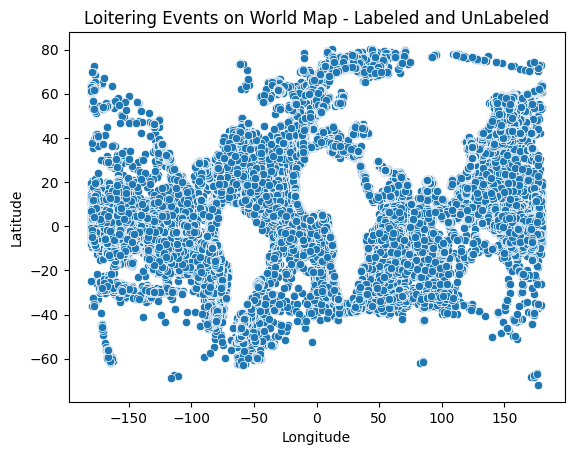

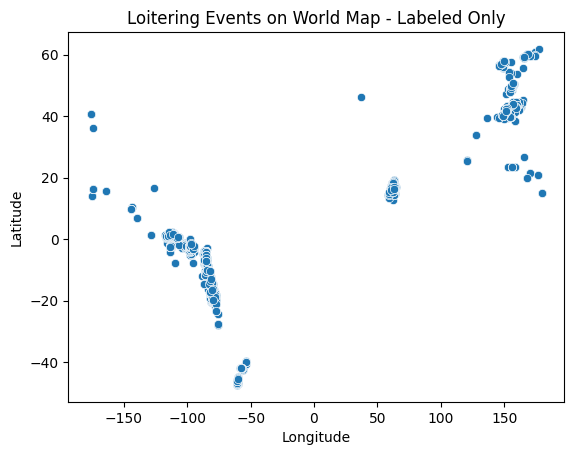

In [52]:
## See locations of all loitering events using latitude and longitude
# ALL DATAPOINTS
ax2 = sns.scatterplot(data=df_loiter_data, x="mean_lon",y="mean_lat")
ax2.set(title="Loitering Events on World Map - Labeled and UnLabeled", xlabel="Longitude", ylabel="Latitude")
plt.show()
# LABELED DATA ONLY
ax1 = sns.scatterplot(data=df_loiter_data_labeled, x="mean_lon",y="mean_lat")
ax1.set(title="Loitering Events on World Map - Labeled Only", xlabel="Longitude", ylabel="Latitude")
plt.show()

In [70]:
# Select only numeric columns
numeric_df = df_loiter_data.select_dtypes(include=[np.number])

print(numeric_df.columns)


Index(['mmsi', 'carrier_mmsi', 'start_lat', 'start_lon', 'end_lat', 'end_lon',
       'mean_lon', 'mean_lat', 'loitering_hours', 'tot_distance_nm',
       'avg_speed_knots', 'avg_distance_from_shore_nm', 'bunker_mmsi',
       'loitering_start_hour', 'response'],
      dtype='object')


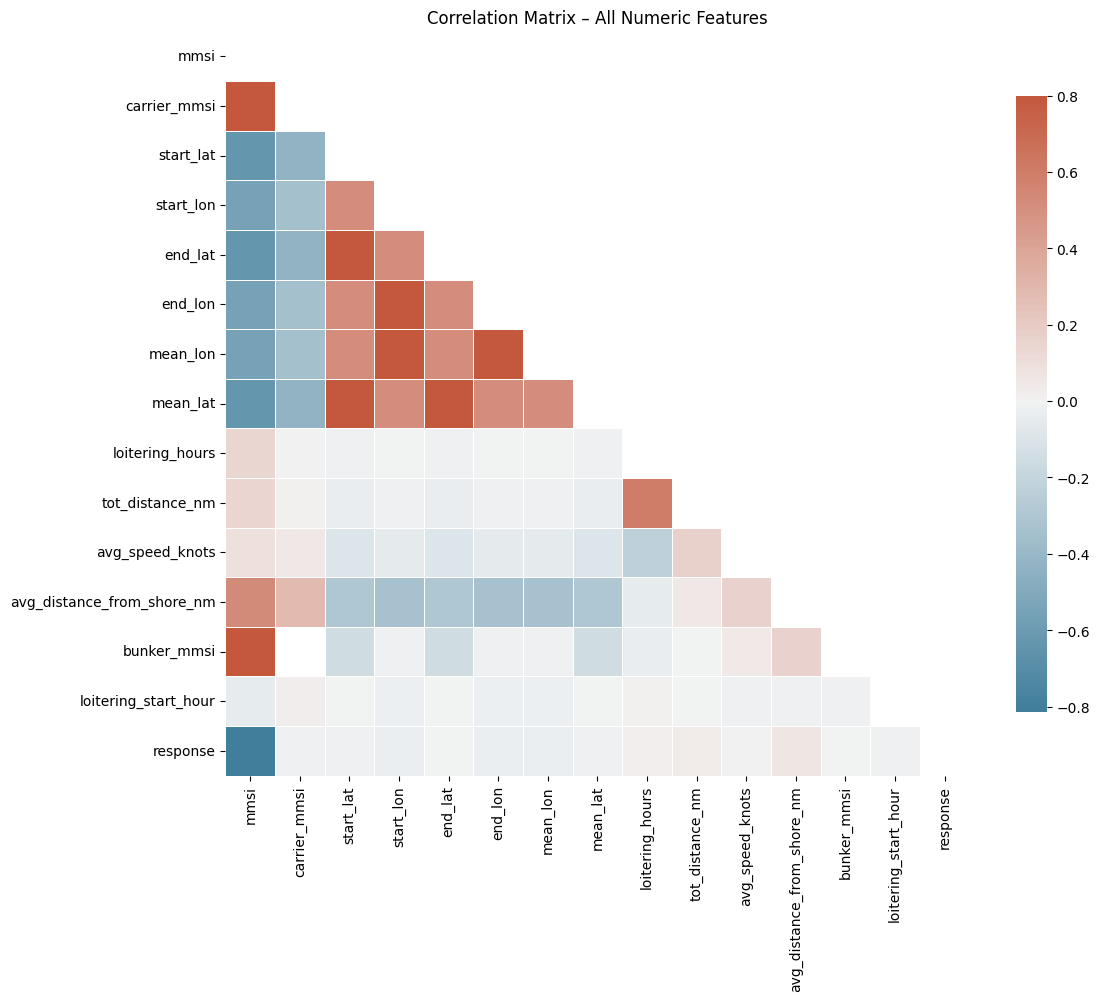

In [71]:
corr = numeric_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.8,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix – All Numeric Features")
plt.show()


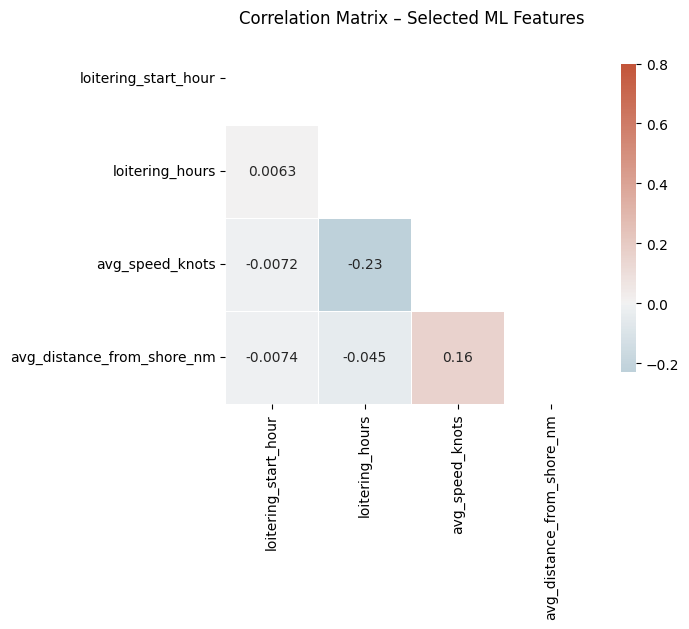

In [72]:
corr = df_raw_all.drop(columns="response").corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.8,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True
)
plt.title("Correlation Matrix – Selected ML Features")
plt.show()


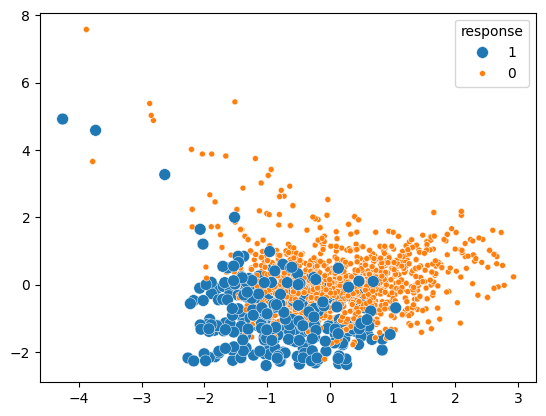

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split

# First Scale Data
scaler = StandardScaler()
df_raw_all_scaled = scaler.fit_transform(df_raw_all.drop(columns='response'))
df_raw_labeled_scaled = scaler.fit_transform(df_raw_labeled.drop(columns='response'))
df_raw_unlabeled_scaled = scaler.fit_transform(df_raw_unlabeled.drop(columns='response'))

# Get Train/Test datasets
X_train = df_raw_labeled_scaled
y_train = df_loiter_data_labeled['response']
X_test = df_raw_all_scaled
y_test = df_loiter_data['response']

# Perform PCA
pca = PCA(3, whiten=True)
PCs = pca.fit(X_train).transform(X_train)
PC1,PC2,PC3 = np.split(PCs, 3, 1)
sns.scatterplot(x=PC1.ravel(), y=PC2.ravel(), hue=y_train.astype(str), size=y_train.astype(str))
plt.show()

In [73]:
# Import required packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, balanced_accuracy_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal as mvn
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

In [58]:
# Perform Train/Test Splits
scaler = StandardScaler()
df_raw_all_scaled = scaler.fit_transform(df_raw_all.drop(columns='response'))
df_raw_labeled_scaled = scaler.fit_transform(df_raw_labeled.drop(columns='response'))
df_raw_unlabeled_scaled = scaler.fit_transform(df_raw_unlabeled.drop(columns='response'))

df_raw_all_labels = df_raw_all['response']
df_raw_labeled_labels = df_raw_labeled['response']

X_train, X_test, y_train, y_test = train_test_split(df_raw_labeled_scaled, df_raw_labeled_labels, test_size=0.2)

In [59]:
# Setup F-beta scorer
from sklearn.metrics import make_scorer, fbeta_score

BETA = 2.0
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

In [60]:
# Train Model - Implement GridseachCV and perform Hyperparameter Tuning
logreg = LogisticRegression(penalty='l2')
params = {'C':list(np.arange(0.001, 10, 0.1)),'class_weight':[None, 'balanced']}
gcv = GridSearchCV(logreg, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

best_model = gcv.best_estimator_
display(best_model)
y_pred = best_model.predict(X_test)
print(f"Bal. Accuracy - Train Set: {balanced_accuracy_score(y_train,best_model.predict(X_train))}")
print(f"Bal. Accuracy - Test Set: {balanced_accuracy_score(y_test,best_model.predict(X_test))}")
print("Confusion Matrix:")
display(confusion_matrix(y_test, y_pred))
print("Classification Report")
print(classification_report(y_test, best_model.predict(X_test)))

LogisticRegression(C=np.float64(9.100999999999999), class_weight='balanced')

Bal. Accuracy - Train Set: 0.8836934689137872
Bal. Accuracy - Test Set: 0.9233177528882617
Confusion Matrix:


array([[358,  33],
       [  4,  54]])

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       391
           1       0.62      0.93      0.74        58

    accuracy                           0.92       449
   macro avg       0.80      0.92      0.85       449
weighted avg       0.94      0.92      0.92       449



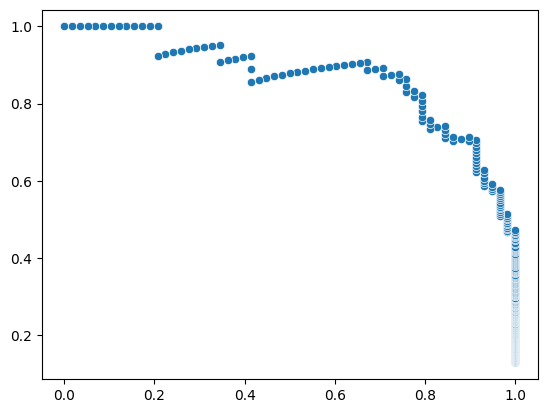

np.float64(0.6682589845371052)

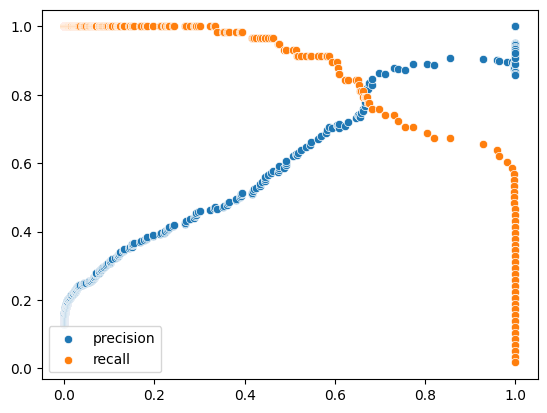

In [61]:
# Example plot
precision, recall, thresholds = precision_recall_curve(y_test,best_model.predict_proba(X_test)[:,1])
sns.scatterplot(x=recall, y=precision)
plt.show()
idx = np.argmin(np.abs(precision-recall))
display(thresholds[idx])
sns.scatterplot(x=thresholds, y=precision[:-1], label='precision')
sns.scatterplot(x=thresholds, y=recall[:-1], label='recall')
plt.show()

In [62]:
gmm = GaussianMixture(n_components=2, covariance_type='full', init_params='random')
gmm.fit(X_train)
y_pred = gmm.predict(X_test)
print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)

0.6926503340757239


array([[305,  86],
       [ 52,   6]])

In [63]:
params = {'C': np.arange(0.0005, 0.01, 0.005),
          'class_weight': [None, 'balanced'],
          'kernel': ['linear', 'rbf'],
        }
svm = SVC(probability=True)
gcv = GridSearchCV(svm, param_grid=params, scoring='balanced_accuracy')
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

svm_best = gcv.best_estimator_ # Get best model
# Get train and test error
print(f"Bal. Accuracy - Train Set: {balanced_accuracy_score(y_train,svm_best.predict(X_train))}")
print(f"Bal. Accuracy - Test Set: {balanced_accuracy_score(y_test,svm_best.predict(X_test))}")
print("Confusion Matrix:")
display(confusion_matrix(y_test, svm_best.predict(X_test)))
print("Classification Report")
print(classification_report(y_test, svm_best.predict(X_test)))

Bal. Accuracy - Train Set: 0.8639461653537541
Bal. Accuracy - Test Set: 0.8875562218890554
Confusion Matrix:


array([[357,  34],
       [  8,  50]])

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       391
           1       0.60      0.86      0.70        58

    accuracy                           0.91       449
   macro avg       0.79      0.89      0.82       449
weighted avg       0.93      0.91      0.91       449



In [64]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': list(range(2,20)),
          'min_samples_split': list(range(2,30)),
        }
cart = DecisionTreeClassifier()
gcv = GridSearchCV(cart, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

cart_best = gcv.best_estimator_ # Get best model
cart_best.fit(X_train, y_train)  # Train best model
#visualize = plot_tree(cart_best)

# Get train and test error
cart_best.score(X_test, y_test)
y_pred = cart_best.predict(X_test)
display(confusion_matrix(y_test, y_pred))

array([[383,   8],
       [ 16,  42]])

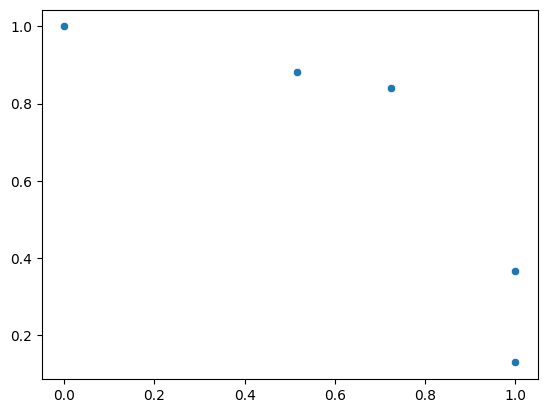

np.float64(0.639344262295082)

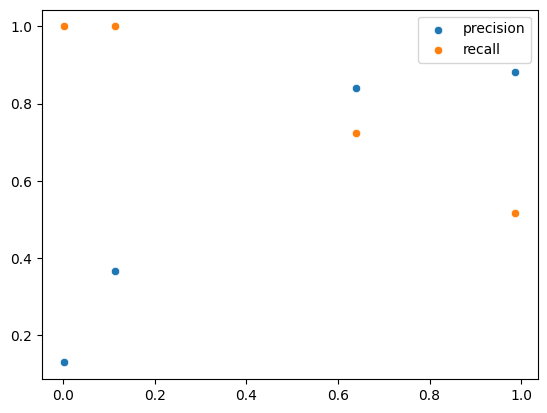

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test,cart_best.predict_proba(X_test)[:,1])
sns.scatterplot(x=recall, y=precision)
plt.show()
idx = np.argmin(np.abs(precision-recall))
display(thresholds[idx])
sns.scatterplot(x=thresholds, y=precision[:-1], label='precision')
sns.scatterplot(x=thresholds, y=recall[:-1], label='recall')
plt.show()

In [66]:
params = {'n_estimators': list(range(1,100))
        }
rf = RandomForestClassifier(max_depth=5,
                            criterion='entropy',
                            class_weight='balanced')
gcv = GridSearchCV(rf, param_grid=params, scoring=fbeta_scorer)
gcv.fit(df_raw_labeled_scaled, df_raw_labeled_labels)

rf_best = gcv.best_estimator_ # Get best model
rf_best.fit(X_train, y_train)  # Train best model
#visualize = plot_tree(rf_best)

# Get train and test error
rf_best.score(X_test, y_test)
y_pred = rf_best.predict(X_test)
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, rf_best.predict(X_test)))

array([[353,  38],
       [  9,  49]])

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       391
           1       0.56      0.84      0.68        58

    accuracy                           0.90       449
   macro avg       0.77      0.87      0.81       449
weighted avg       0.92      0.90      0.90       449



In [67]:
# Pickle Scaler
with open("scaler",'wb') as file:
    pickle.dump(scaler,file)

# Pickle RandomForest Model that was chosen
with open("model",'wb') as file:
    pickle.dump(rf_best,file)

In [68]:
# Pickle scaler
with open("scaler",'wb') as file:
    pickle.dump(scaler,file)

In [74]:
# Setup CV
MAX_DEPTH = 9
THRESHOLD = 0.9
ITERATIONS = 5
BETA = 2.0

# Setup F-beta scorer
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

# Setup splits
X_train, X_test, y_train, y_test = train_test_split(df_raw_labeled_scaled, df_raw_labeled_labels, test_size=0.2)


params = {'n_estimators': list(range(1,100))}
rf = RandomForestClassifier(max_depth=MAX_DEPTH,
                            criterion='entropy',
                            class_weight='balanced')
gcv = GridSearchCV(rf, param_grid=params, scoring=fbeta_scorer)
gcv.fit(X_train, y_train)

rf_best = gcv.best_estimator_ # Get best model

# Get train and test error
rf_best.score(X_test, y_test)
y_pred = rf_best.predict(X_test)
print("---- Supervised Training ----")
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, rf_best.predict(X_test)))

with open("Sup_model_train",'wb') as file:
    pickle.dump(rf_best,file)

# Prepare data
training_features = X_train.copy()
training_labels = y_train.copy()
unlabeled_features = df_raw_unlabeled_scaled.copy()

# Import trained supervised model
with open("Sup_model_train",'rb') as file:
    model = pickle.load(file)

# Run SSL
for i in range(ITERATIONS):

    # Predict probabilities of unlabeled set
    pred = model.predict_proba(unlabeled_features)[:,1]

    # Get indexes of pseudo-labels that meet the threshold
    #idxs = np.where((pred > THRESHOLD) | (pred < 1-THRESHOLD))[0]
    idxs = np.where((pred > THRESHOLD) | (pred < 1-THRESHOLD))[0]
    idxs = idxs[:300]   # LIMIT growth to avoid freezing

    # Append features
    training_features = np.concatenate([training_features,df_raw_unlabeled_scaled[idxs]])

    # Append pseudo-labels
    training_labels = np.concatenate([training_labels, pred[idxs].round(0).astype(int)])

    # Remove idxs from unlabeled sets
    remove_idxs = np.where(~((pred > THRESHOLD) | (pred < 1-THRESHOLD)))[0]
    unlabeled_features = unlabeled_features[remove_idxs]

    # Retrain model
    model.fit(training_features,training_labels)

    # Break conditions
    if(len(unlabeled_features) < 50 or len(idxs) == 0):
        break

with open("SSL_final_model",'wb') as file:
    pickle.dump(model,file)

with open("SSL_final_labels",'wb') as file:
    pickle.dump(np.concatenate([training_features, training_labels[:,None]], axis=1),file)

print("---- SSL Training Error ----")
display(confusion_matrix(training_labels,model.predict(training_features)))
print(classification_report(training_labels, model.predict(training_features)))


print("---- SSL Test Error ----")
display(confusion_matrix(y_test,model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

---- Supervised Training ----


array([[379,   9],
       [ 20,  41]])

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       388
           1       0.82      0.67      0.74        61

    accuracy                           0.94       449
   macro avg       0.88      0.82      0.85       449
weighted avg       0.93      0.94      0.93       449

---- SSL Training Error ----


array([[1757,   65],
       [ 259, 1214]])

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1822
           1       0.95      0.82      0.88      1473

    accuracy                           0.90      3295
   macro avg       0.91      0.89      0.90      3295
weighted avg       0.91      0.90      0.90      3295

---- SSL Test Error ----


array([[375,  13],
       [ 16,  45]])

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       388
           1       0.78      0.74      0.76        61

    accuracy                           0.94       449
   macro avg       0.87      0.85      0.86       449
weighted avg       0.93      0.94      0.93       449



In [75]:
# Import trained final model
with open("SSL_final_model",'rb') as file:
    final_model = pickle.load(file)

with open("SSL_final_labels",'rb') as file:
    final_dataset = pickle.load(file)

with open("scaler",'rb') as file:
    final_scaler = pickle.load(file)

pred = final_model.predict(final_dataset[:,0:-1])

# Prep data
idx = np.where(final_dataset[:,-1] == 1)
training_data = final_dataset[idx, 0:-1][0]

In [76]:
# Train Model
ocsvm = OneClassSVM(kernel='linear')
ocsvm.fit(training_data)

# Get train and test error
y_pred = ocsvm.predict(X_test) # 1 for inliers, -1 for outliers
y_pred[np.where(y_pred == -1)] = 0
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

array([[386,   2],
       [ 26,  35]])

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       388
           1       0.95      0.57      0.71        61

    accuracy                           0.94       449
   macro avg       0.94      0.78      0.84       449
weighted avg       0.94      0.94      0.93       449



In [77]:
# Save model
with open("Anomaly_model",'wb') as file:
    pickle.dump(ocsvm,file)

In [78]:
df = pd.DataFrame({'y_test': np.asarray(y_test),
                   'y_pred': y_pred,
                   'y_scores': ocsvm.score_samples(X_test)})

# +1 is FP, -1 is FN
df['mismatch'] = df['y_pred'] - df['y_test']
df['Type'] = df['mismatch'].apply(lambda x: 'FN' if x==-1 else ('FP' if x==1 else 'TP & TN'))

Text(0, 0.5, 'OCSVM Score')

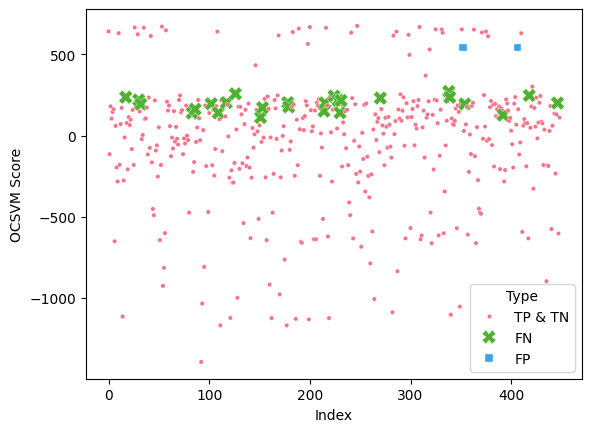

In [79]:
sns.scatterplot(data=df, x=df.index, y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("Index")
plt.ylabel("OCSVM Score")

Text(0, 0.5, 'OCSVM Score')

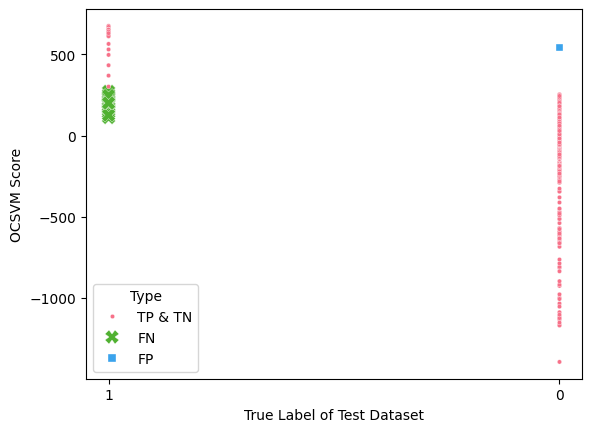

In [80]:
sns.scatterplot(data=df, x=df['y_test'].astype(str), y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("True Label of Test Dataset")
plt.ylabel("OCSVM Score")

Text(0, 0.5, 'OCSVM Score')

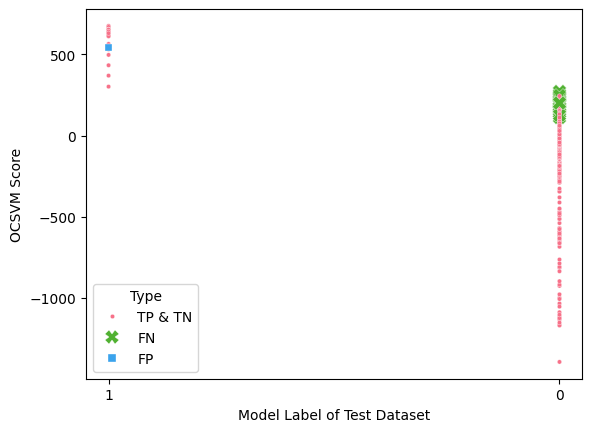

In [81]:
# Shows FN are clustered at lower end of the scoring, so scoring can be used to rank
# FP doesn't matter
sns.scatterplot(data=df, x=df['y_pred'].astype(str), y='y_scores', hue='Type', palette='husl', style='Type', size='Type', size_order=['TP & TN', 'FP', 'FN'], sizes=(100,10))

plt.xlabel("Model Label of Test Dataset")
plt.ylabel("OCSVM Score")

In [82]:
# Feature Importance
a,b,c,d = model.feature_importances_
print("Importance Scores:")
print(f"Loitering Start Hour: {round(a*100,4)}%")
print(f"Loitering Total Hours: {round(b*100,4)}%")
print(f"Average Speed (knots): {round(c*100,4)}%")
print(f"Average Distance from Shore (nautical miles): {round(d*100,4)}%")

Importance Scores:
Loitering Start Hour: 8.9306%
Loitering Total Hours: 10.3259%
Average Speed (knots): 5.708%
Average Distance from Shore (nautical miles): 75.0354%


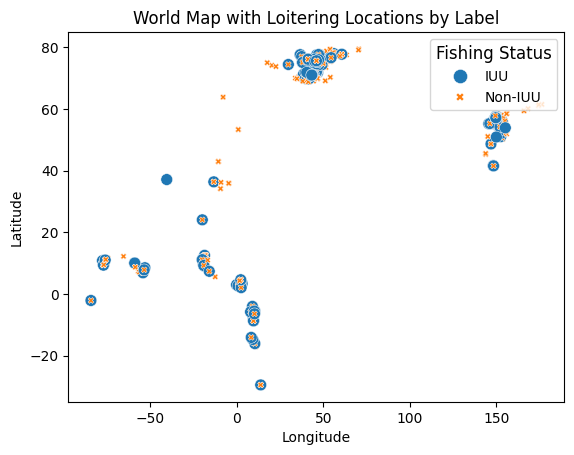

In [85]:
from matplotlib.legend_handler import HandlerPathCollection

x = np.concatenate([final_scaler.inverse_transform(final_dataset[:,:-1]),final_dataset[:,-1][:,None]], axis=1)
df_end = pd.DataFrame(x, columns=['loitering_start_hour', 'loitering_hours', 'avg_speed_knots','avg_distance_from_shore_nm','response'])

y = df_loiter_data.merge(df_end, how='inner', on=['loitering_hours', 'avg_speed_knots','avg_distance_from_shore_nm'])
y = y.rename(columns={'response_y':"Label"})
y['Label'] = y['Label'].apply(lambda x: "IUU" if x==0 else 'Non-IUU')

sc = sns.scatterplot(data=y, x="mean_lon",y="mean_lat", hue='Label', size='Label', style='Label')
plt.title('World Map with Loitering Locations by Label')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(
    title="Fishing Status",
    fontsize=10,
    title_fontsize=12,
    markerscale=1.2,
    loc="upper right",
    frameon=True
)

plt.show()